# 2 Machine learning for regression
This chapter covers:
- Creating a car-price prediction proejct with a linear regression model
- Doing an initial exploratory data analysis with Jupyter notebooks
- Setting up a validation framework
- Implementing the linear regression model from scratch
- Performing simple feature engineering for the model
- Keeping the model under control with regularization
- Using the model to predict car prices

## 2.1 Car-price prediction project

## Preparation

In [226]:
%pip install -r requirements.txt -q

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
Note: you may need to restart the kernel to use updated packages.


In [227]:
from utils import ensure_correct_directory


ensure_correct_directory("chapter-02")

'chapter-02'

### 2.1.1 Downloading the dataset

## 2.2 Exploratory data analysis
Look at the dataset to learn
- The distribution of the target variable
- The features in the dataset
- The distribution of values in these features
- The quality of the data
- The number of missing values


### 2.2.1 Exploratory data analysis toolbox


In [228]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

### 2.2.2 Read and preparing data

In [229]:
df = pd.read_csv("data/data.csv")

In [230]:
len(df)

11914

In [231]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [232]:
# fix column names
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [233]:
string_columns = list(df.dtypes[df.dtypes == "object"].index)

for col in string_columns:
  df[col] = df[col].str.lower().str.replace(" ", "_")

In [234]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


The result of preprocessing the data. the column names and values are normalized.

### 2.2.3 Target variable analysis
The MSRP column contains the important information - it's the target variable $y$, which is the value that we want to learn to predict.

First step to look at what the vlaues of $y$ look like. Typically it is done by checking the distribution of $y$: a visual description of what the possible values of $y$ can be and how often they occur. This type of visualization is called a *histogram*.

<AxesSubplot:xlabel='msrp', ylabel='Count'>

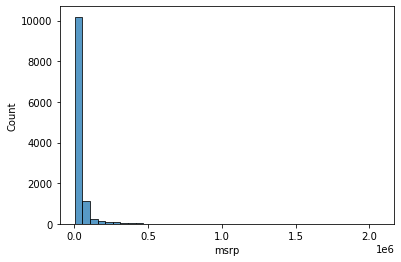

In [235]:
sns.histplot(df.msrp, bins=40)

<AxesSubplot:xlabel='msrp', ylabel='Count'>

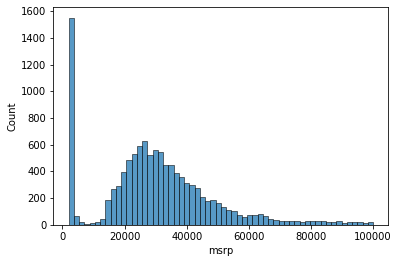

In [236]:
sns.histplot(df.msrp[df.msrp < 100000])

The long tail makes it quite difficult for us to see the distribution, but it has an even stronger effect on a model: such distribution can greatly confuse the model. To solve this problem is log transformation. Apply the log function to the prices, it removes the undesired effect

$ y_{new} = log(y + 1)$

The $+1$ part is important in case that have zeros. The logarithm of zero is minus infinity, but the logarithm of one is zero. If vlaues are all non-negative, by adding 1, it make sure that the transformed values do not go below zero.

In [237]:
log_price = np.log1p(df.msrp)

<AxesSubplot:xlabel='msrp', ylabel='Count'>

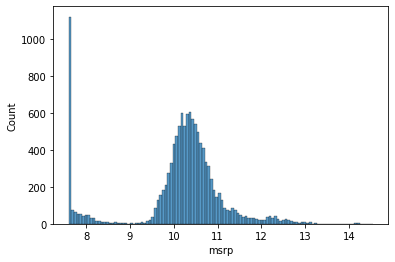

In [238]:
sns.histplot(log_price)

The transformation removes the long tail, and now the distribution resembles a bell-shaped curve. This distribution is not normal, of course, because of the large peak in lower prices, but the model can deal with it more easily.

**[NOTE]** Generally, it's good when the target distribution looks like the normal distribution. Models such as linear regression perform well. The normal distribution, also known as **Gaussian**, follows the bell-shaped curve, which is symmetrical and has a peak in the center.

### 2.2.4 Checking for missing values

In [239]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

### 2.2.5 Validation Framework
Sometimes these optimization methods pick up spurious patterns - patterns that appear to be real patterns to the model but in reality are random flucturations.

The entire dataset is split into 3 parts: train, validation and test
- Training: 60%
- Validation: 20%
- Test: 20%

In [240]:
n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

np.random.seed(2)
idx = np.arange(n)

np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train + n_val].copy()
df_test = df_shuffled.iloc[n_train + n_val:].copy()

In [241]:
np.random.seed(2)

idx = np.arange(5)

print('before shuffle', idx)

np.random.shuffle(idx)

print('after shuffle', idx)

before shuffle [0 1 2 3 4]
after shuffle [2 4 1 3 0]


In [242]:
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

In [243]:
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

## 2.3 Machine learning for regression
For this project we will use the simplest regression model: linear regression.

### 2.3.1 Linear regression

$ y \approx g(X) $

This is a matrix form. X is a matrix where the features of observation are rows of the matrix, and $y$ is a vector with the values we want to predict.

The index $i$ here means that this is an observation number $i$, one of $m$ observations that we have in our training dataset.

For a single observation:

$ y_{i} \approx g(x_{i}) $

When have $n$ features, the vector $x_{i}$ is n-dimensional, so it has $n$ components:

$ x_{i} = (x_{i1}, x_{i2}, ...,x_{in}) $

The function $g$ can be rewrite as a function with $n$ parameters

$ y_{i} = g(x_{i}) = g(x_{i1}, x_{i2}, ...,x_{in}) $

In this dataset, it have 7,150 cars in the training dataset. This means that $m = 7,150$ and $i$ can be any number between 0 and 7,149.

In this case, the function $g$ has the following signature in Python.

```python
def g(xi):
  # xi is a list with n elements
  # do something with xi
  # return the result
  pass
```

When apply the function $g$ to a vector $xi$, it produces $y_pred$ as the output, which is the $g$'s prediction for $xi$:

$ y_{pred} = g(x_{i}) $

There are many ways the function $g$ could look, and the choice of a machine learning algorithm defines the way it works.

If $g$ is the **linear regression** model, it has the following form:

$ g(x_{i}) = g(x_{i1}, x_{i2}, ..., x_{in}) = w_0 + x_{i1}w_1 + x_{i2}w2 + ... + x_{in}w_n $

The variables $w_0, w_1, w_2, ..., w_n$ are the parameters of the model

- $w_0$ is the *bias* term
- $w_1, w_2, ...w_n$ are the *weights for each feature $x_{i1}, x_{i2}, ... x_{in}$

$ g(x_{i}) = g(x_{i1}, x_{i2}, ..., x_{in}) = w_0 + \sum_{j=1}^{n}x_{ij}w_{j} $

In code:
```python
result = w0 + xi[0] * w[0] + xi[1] * w[1] + xi[2] * w[2]
```

Because both features and weights are bectors $x_i$ and $w$, respectively, we can replcae the sum of the elements of these vectors with a dot product between them.

$ x_i^Tw = \sum_{j=1}^n x_{ij}w_{j} = x_{i1}w_1 + x_{i2}w_2 + ... + x_{in}w_n $

In code:
```python
def dot(xi, w):
  n = len(w)

  result = 0.0

  for j in range(n):
    result = result + xi[i] * w[j]
  
  return result
```

Using the new notation, we can rewrite the entire equation for lienar regression as

$ g(x_i) = w_0 + x_i^Tw $

where
- $w_0$ is the bias term.
- $w$ is the n-dimensional vector of weights.

By appending $w_0$ into the weights vector and a dummy feature (value 1) to the features vector. We can expression the model as the dot product between the new $x_i$ and the new $w$:

$ g(x_{i}) = x_i^Tw$


There are many observations and $x_i$ is one of them. Thus, we have $m$ feature vectors $x_1, x_2, ... x_m$ and each of these vectors consists of $n+1$ features

$ x_1 = (1, x_{11}, x_{12}, ..., x_{1n}) $

$ x_2 = (1, x_{21}, x_{22}, ..., x_{2n}) $

$ x_i = (1, x_{i1}, x_{i2}, ..., x_{in}) $

$ x_m = (1, x_{m1}, x_{m2}, ..., x_{mn}) $

$ g(X) = w_0 + Xw $

### 2.3.2 Training linear regression model
To learn the weights from data, we use the target variable $y$ to find such $w$ that combines the features of $X$ in the best possible way. **Best possible** in the case of linear regression means that it minimizes the error between the predictions $g(X)$ and the actual target $y$.

The weight vector $w$ can be computed with the following formula:

$ w = (X^TX)^{-1}X^Ty $

Translating to NumPy:
- $X^T$ is the transpose of $X$. In NumPy, it's `X.T`
- $X^TX$ is a matrix-matrix multiplication, which can be done with ther `dot` method from NumPy: `X.T.dot(X)`
- $X^{-1}$ is the inverse of $X$. We can use `np.linalg.inv` function to calculate the inverse

So the formula above translates to

```python
inv(X.T.dot(X)).dot(X.T).dot(y)
```

To implement the normal equation
1. Create a function that takes a matrix $X$ with features and a vector $y$ with the target
2. Add a dummy column (the feature that is always set to 1) to the matrix $X$
3. Train the model: compute the weight $w$ by using the normal equation
4. Split this $w$ into the bias $w_0$ and the rest of the weights and return them

The last step - splitting $w$ into the bias term and the rest - is optional, and mostly for convenience; otherwise, we need to add the dummy column every time we want to make prediction instead of doing it once during traning.


In [244]:
def train_linear_regression(X, y):
  # adding the dummy column
  ones = np.ones(X.shape[0])
  X = np.column_stack([ones, X])

  # normal equation formula
  XTX = X.T.dot(X)
  XTX_inv = np.linalg.inv(XTX)
  w = XTX_inv.dot(X.T).dot(y)

  return w[0], w[1:]

In [245]:
ones = np.array([1, 1])

X = np.array([[2, 3,], [4, 5]])

np.column_stack([ones, X])

array([[1, 2, 3],
       [1, 4, 5]])

## 2.4 Predicting the price

### 2.4.1 Baseline solution
To start with a very naive way of creating features by select a few numerical features and form the matrix $X$ from them.

- engine_hp
- engine_cylinders
- highway_mpg
- city_mpg
- popularity


In [246]:
base = [
  "engine_hp",
  "engine_cylinders",
  "highway_mpg",
  "city_mpg",
  "popularity"
]

df_num = df_train[base]

AS discuessed previously on exploratory data analysis, the dataset has missing values. It needs to be handled because linear regression model cannot deal with missing values automatically.

A simplest possible approach is to fill the missing values with zeros. This method may not be the best way to deal with missing values, but often it's good enough. If we set the missing feature value to zero, the respective feature is simply ignored.

**NOTE:** An alternative option is to replace the missing values with the average values. 

In [247]:
df_num = df_num.fillna(0)

Recall that the formula of linear regression. If a feature $x_in$  is missing, reguardless of the weight $w_n$ for this feature, the product $x_{in}w_n$ will always be zero. In other words, this feature will have no contribution to the final prediction, and we will base our prediction only on features that aren't missing

In [248]:
# Convert DataFrame to NumPy array
X_train = df_num.values

X_train

array([[ 148.,    4.,   33.,   24., 1385.],
       [ 132.,    4.,   32.,   25., 2031.],
       [ 148.,    4.,   37.,   28.,  640.],
       ...,
       [ 285.,    6.,   22.,   17.,  549.],
       [ 563.,   12.,   21.,   13.,   86.],
       [ 200.,    4.,   31.,   22.,  873.]])

In [249]:
w_0, w = train_linear_regression(X_train, y_train)

In [250]:
y_pred = w_0 + X_train.dot(w)

y_pred

array([ 9.54792783,  9.38733977,  9.67197758, ..., 10.30423015,
       11.9778914 ,  9.99863111])

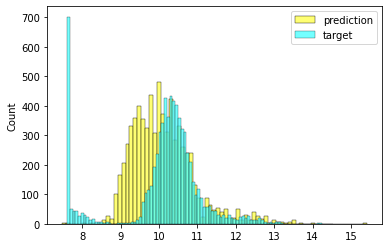

In [251]:
sns.histplot(y_pred, label="prediction", color="#FFFF44")
sns.histplot(y_train, label="target", color="#44FFFF")
plt.legend()

### 2.4.2 RMSE: Evaluating model quality
It is required to use a metric that quantifies the quality of the model. The most commonly used one is *root mean squared error* - RMSE for short

RMSE tells us how large the errors are that our model makes

$ RMSE = \sqrt{\frac{1}{m}\sum^m_{i=1}(g(x_{i}) - y_{i})^2} $

First let's look inside the sum 

$ (g(x_{i}) - y_{i})^2 $

This is the difference between the prediction we make for the observation and the actual target value for that observation 

It gives a lot more weight to larger differences by using the square of the difference. this is the SE (squared error) part of RMSE.

$ \sum^m_{i=1}(g(x_{i}) - y_{i})^2 $

The summation goes over all $m$ observations and puts all the squared errors together into a single number.

If we divide this sum by $m$, we get the mean squared error

This is the squared error that our model makes on average - the M part (mean) of RMSE, or *mean squared error* (MSE). MSE is also a good metric on its own.

Finally, we take the square root of that.

In [252]:
def rmse(y, y_pred):
  error = y_pred - y
  mse = (error ** 2).mean()
  return np.sqrt(mse)

In [253]:
rmse(y_train, y_pred)

0.7554192603920132

### 2.4.3 Validating the model

In [254]:
df_num = df_val[base]
df_num = df_num.fillna(0)

X_val = df_num.values

In [255]:
y_pred = w_0 + X_val.dot(w)

In [256]:
rmse(y_val, y_pred)

0.7616530991301608

In [257]:
def prepare_X(df):
  df_num = df[base]
  df_num = df_num.fillna(0)
  X = df_num.values
  return X

In [258]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print("Validation: ", rmse(y_val, y_pred))

Validation:  0.7616530991301608


### 2.4.4 Simple feature engineering

In [259]:
df_train["age"] = 2017 - df_train.year

In [260]:
def prepare_X(df):
  df = df.copy()
  features = base.copy()

  df["age"] = 2017 - df.year
  features.append("age")

  df_num = df[features]
  df_num = df_num.fillna(0)
  X = df_num.values
  return X

In [261]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print("Validation: ", rmse(y_val, y_pred))

Validation:  0.5172055461058325


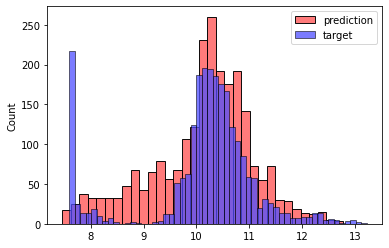

In [262]:
sns.histplot(y_pred, label="prediction", color="#FF4F4F")
sns.histplot(y_val, label="target", color="#4F4Fff")
plt.legend()

### 2.4.5 Handing categorical variables
**Categorical variables** describe characteristics of objects and can take  one of a few possible values. 

Categorical variables in a machine learning model can be used in multiple ways. One of the simplist ways is to encode such variables by a set of binary features, with a seperate feature of each distinct value.

This method of encoding categorical variable is call **one-hot encoding** 

In [263]:
def prepare_X(df):
  df = df.copy()
  features = base.copy()

  df["age"] = 2017 - df.year
  features.append("age")

  for v in [2, 3, 4]:
    feature = f"nun_doors_{v}"
    value = (df["number_of_doors"] == v).astype(int)
    df[feature] = value
    features.append(feature)

  df_num = df[features]
  df_num = df_num.fillna(0)
  X = df_num.values
  return X

In [264]:
top_5_makers = df["make"].value_counts().head(5).keys().array

In [265]:
 def prepare_X(df):
  df = df.copy()
  features = base.copy()

  df["age"] = 2017 - df.year
  features.append("age")

  for v in [2, 3, 4]:
    feature = f"nun_doors_{v}"
    value = (df["number_of_doors"] == v).astype(int)
    df[feature] = value
    features.append(feature)

  for v in top_5_makers:
    feature = f"is_make_#{v}"
    df[feature] = (df["make"] == v).astype(int)
    features.append(feature)
  

  df_num = df[features]
  df_num = df_num.fillna(0)
  X = df_num.values
  return X

In [266]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print("Validation: ", rmse(y_val, y_pred))

Validation:  0.5076038849555975


In [267]:
def binary_encode(df, column=None, prefix=None, types=[], features=[]):
  for t in types:
    feature = f"{prefix}_{t}"
    value = (df[column] == t).astype(int)
    df[feature] = value
    features.append(feature)


In [268]:
ENGINE_FUEL_TYPES = [
  "regular_unleaded", 
  "premium_unleaded_(required)",
  "premium_unleaded_(recommended)",
  "flex-fuel_(unleaded/e85)"
]

TRANSMISSION_TYPES = [
  "automatic",
  "manual",
  "automated_manual"
]

DRIVEN_WHEELS = [
  "front_wheel_drive",
  "rear_wheel_drive",
  "all_wheel_drive",
  "four_wheel_drive"
]

MARKET_CATEGORIES = [
  "crossover",
  "flex_fuel",
  "luxury",
  "luxury,performance",
  "hatchback"
]

VEHICLE_SIZES = [
  "compact",
  "midsize",
  "large"
]

VEHICLE_STYLES = [
  "sedan",
  "4dr_suv",
  "coupe",
  "convertible",
  "4dr_hatchback"
]

def prepare_X(df):
  df = df.copy()
  features = base.copy()

  df["age"] = 2017 - df.year
  features.append("age")

  binary_encode(
    df, 
    column="number_of_doors",
    prefix="num_doors", 
    types=[2, 3, 4], 
    features=features)

  binary_encode(
    df, 
    column="make",
    prefix="is_make_",
    types=top_5_makers,
    features=features
  )

  binary_encode(
    df, 
    column="engine_fuel_type",
    prefix="is_type",
    types=ENGINE_FUEL_TYPES,
    features=features
  )

  binary_encode(
    df, 
    column="transmission_type",
    prefix="is_transmission",
    types=TRANSMISSION_TYPES,
    features=features
  )

  binary_encode(
    df, 
    column="driven_wheels",
    prefix="is_driven_wheels",
    types=DRIVEN_WHEELS,
    features=features
  )
  
  binary_encode(
    df, 
    column="market_category",
    prefix="is_mc",
    types=MARKET_CATEGORIES,
    features=features
  )

  binary_encode(
    df, 
    column="vehicle_size",
    prefix="is_size",
    types=VEHICLE_SIZES,
    features=features
  )

  binary_encode(
    df, 
    column="vehicle_style",
    prefix="is_style",
    types=VEHICLE_STYLES,
    features=features
  )

  df_num = df[features]
  df_num = df_num.fillna(0)
  X = df_num.values
  return X

In [269]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print("Validation: ", rmse(y_val, y_pred))

Validation:  28.59371166289286


### 2.4.6 Regularization
Adding new features does not always help. The reason for this behavior is numerical instability. Recall the formula of the normal equation:

$ w = (X^TX)^{-1}X^Ty $

One of the terms in the equation is the inverse of the $X^TX$ matrix. The inversion is the issue in our case. Sometimes, when adding new columns to $X$, it can accidentally add a column that is a combination of other columns.

For example, if we already have the MPG in the city feature and decide to add kilometers per liter in the city, the second feature is the same as the first one but multiplied by a constant.

When this happens, $X^TX$ becomes *undetermind* or *singular*, which means that it's not possible to find an inverse for this matrix. If we try to invert a singular matrix, NumPy will notify about that by raise a `LinAlgError`

```python
LinAlgError: Singular matrix
```

The code didn't raise any exceptions. It happened because we don't typically have columns that are perfect linear combinations of other columns. The real data is often **noisy**, with measurement errors (such as recording 1.3 instead of 13 for MPG), rounding errors (such as storing 0.0999999 instead of 0.1), and many other errors. Technically, such matrics are not singular, so NumPy doesn't complain.

For this reason, some of the values in the weights become extremely large - a lot large than they are supposed to be.

In numerical linear algebra, such issues are called *numerical instability issues* and they are typically solved with regularization techniques. The aim of *regularization* is to make sure that the inverse exists by forcing the matrix to be invertible. Regularization is an important concept in machine learning: it means "controlling" - controlling the weights of the model so that they behave correctly and don't grow too large, as in our case.

One way to do regularization is to add a small number to each diagonal element of the matrix. Then we get the following formula for linear regression:

**NOTE** Regularized lienar regression is often called *ridge regression*. Many libraries, including Scikit-learn, use *ridge* to refer to regularized linear regression and linear regression to refer to the unregularized model.

$ X^TX + \alpha I $

This formula syas that we need $I$ - an **identify matrix**, which is a matrix with ones on the main diagonal and zerios everywhere else. We multiply this identity matrix by a number $\alpha$. this way, all the ones on the diagonal of $I$ become $\alpha$. Then we sum $\alpha I$ and $X^TX$, wich adds $\alpha$ to all the diagonal elements of $X^TX$.

```python
XTX = X_train.T.dot(X_Train)
XTX = XTX + 0.01 * np.eye(XTX.shape[0])
```

In [270]:
(np.eye(4) * 0.01)

array([[0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.01]])

In [271]:
def train_linear_regression_reg(X, y, r=0.0):
  ones = np.ones(X.shape[0])
  X = np.column_stack([ones, X])

  XTX = X.T.dot(X)
  reg = r * np.eye(XTX.shape[0])
  XTX = XTX + reg
  XTX_inv = np.linalg.inv(XTX)
  w = XTX_inv.dot(X.T).dot(y)
  return w[0], w[1:]

Regularization affects the final solution by making the components of $w$ smaller. We can see that the more regularization we add, the smaller the weights become.

In [272]:
for r in [0, 0.001, 0.01, 0.1, 1, 10]:
  w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
  print('%5s, %.2f, %.2f, %.2f' % (r, w_0, w[13], w[21]))

    0, -7103135791205589.00, -0.67, 7103135791204337.00
0.001, 7.19, -0.10, 1.81
 0.01, 7.18, -0.10, 1.81
  0.1, 7.05, -0.10, 1.78
    1, 6.22, -0.10, 1.56
   10, 4.39, -0.09, 1.08


In [273]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.001)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print("Validation; ", rmse(y_val, y_pred))

Validation;  0.4602267629384194


**NOTE** Sometimes, when adding a new feature causes performance degradation, simply removing this feature may be enough to solve the problem. Having a validation dataset is important to decide whether to add regularization, remove the feature, or do both.

In [274]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)
 
for r in [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
  w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
  y_pred = w_0 + X_val.dot(w)
  print('%6s' %r, rmse(y_val, y_pred))

 1e-06 0.46022581034614773
0.0001 0.4602254991805762
 0.001 0.4602267629384194
  0.01 0.46023949626933275
   0.1 0.4603700695813315
     1 0.4618298042654334
     5 0.4684079627533988
    10 0.47572481006942474


In [275]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.01)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print("Validation: ", rmse(y_val, y_pred))

X_test = prepare_X(df_test)
y_pred = w_0 + X_test.dot(w)
print("Test: ", rmse(y_test, y_pred))

Validation:  0.46023949626933275
Test:  0.457181367918814


### 2.4.7 Using the model

In [145]:
ad = {
  'city_mpg': 18,
  'driven_wheels': 'all_wheel_drive',
  'engine_cylinders': 6.0,
  'engine_fuel_type': 'regular_unleaded',
  'engine_hp': 268.0,
  'highway_mpg': 25,
  'make': 'toyota',
  'market_category': 'crossover,performance',
  'model': 'venza',
  'number_of_doors': 4.0,
  'popularity': 2031,
  'transmission_type': 'automatic',
  'vehicle_size': 'midsize',
  'vehicle_style': 'wagon',
  'year': 2013
}

In [147]:
df_test = pd.DataFrame([ad])
X_test = prepare_X(df_test)

y_pred = w_0 + X_test.dot(w)

suggestion = np.expm1(y_pred)
suggestion

array([28294.13591291])

## Further Readings
- The Elements of Statistical Learning, 2nd edition by Hastie, Tibshirani, and Friedman